# 3.4 Deep Feedforward Neural Network (w/ GAN data)

## 1. Data Load In

In [1]:
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
# cases + conrols df
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

# GAN
gan_data_m = np.load('Ellen Exploratory (Will Delete When Done)/gan_pos_female_ep500_cs3000_si50.npy')
gan_data_f = np.load('gan_pos_male_ep500_cs3000_si50.npy')

In [ ]:
gan_data_m.shape

In [ ]:
gan_data_f.shape

In [ ]:
gan_data_cases = np.concatenate((gan_data_f, gan_data_m))

In [ ]:
gan_data_cases.shape

In [ ]:
total_cases = len(images_paths_f_case) + len(images_paths_m_case) + gan_data_m.shape[0] + gan_data_f.shape[0]
total_controls = len(images_paths_f_control ) + len(images_paths_m_control) #+ gan_control_f.shape[0]
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case) + gan_data_f.shape[0])))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case) + gan_data_m.shape[0])))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

num_im = len(images_paths)
image_array = []

In [3]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue

image_array = np.asarray(image_array).astype('float32')
image_array = np.vstack((image_array,gan_data_cases))  

There are 22 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 124 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 146 total cases and 245 total controls! 391 participants in total


In [5]:
image_array.shape

(491, 61, 73, 61)

In [6]:
pheno = df[['FILE_ID', 'DX_GROUP']]
pheno_array = np.array(pheno['DX_GROUP'])
pheno_array = np.where(pheno_array == 2, 0, pheno_array) # 0 = control, 1 = dx
# distribution
df['DX_GROUP'].value_counts()

2    245
1    146
Name: DX_GROUP, dtype: int64

In [ ]:
# gan_pheno
gan_pheno_cases = np.ones((gan_data_cases.shape[0],), dtype=int)
all_pheno = np.concatenate((pheno_array, gan_pheno_cases))

In [8]:
#training and holdout split
x_train, x_val, y_train, y_val = train_test_split(image_array, all_pheno, test_size = 0.15, random_state = 654)

#training and testing split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 654)

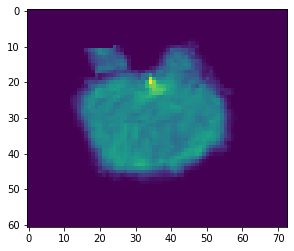

In [9]:
plt.imshow(x_train[15][48].T)

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 16
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

## 2. Model

### 2.1 Highest performing DFNN architecture from Mellema 2022 ** Best Performing with GAN data **

In [ ]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

In [ ]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_DFNN.h5", save_best_only=True
#)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=10)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

In [ ]:
# # Save the weights
# model.save_weights('DFNN_DoubleActuals_mod1.h5')

In [ ]:
# # # Load best weights.
# model.load_weights("DFNN_DoubleActuals_mod1.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
    "This model is %.2f percent confident that CT scan is %s"
    % ((100 * score), name))
print(y_test[0])

In [ ]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

In [ ]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
auc_keras

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# from PIL import ImageFont
# font = ImageFont.truetype("Arial.ttf", 16)
# visualkeras.layered_view(model, legend=True,font = font, to_file='DFNN1arch_gan.png')  # font is optional!

### 2.2 Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications

In [ ]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications."""

    inputs = keras.Input((width, height, depth, 1))  
     
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.95, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

In [ ]:
#evaluate on the holdout data
model.evaluate(x_val, y_val)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

In [ ]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
y_pred_keras = model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [ ]:
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
auc_keras

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 2.3 Complex Highest performing Dense FNN neural network model from Mellema 2022 with modifications

In [ ]:
def Dense_model(width=61, height=73, depth=61):
    """Build a complex Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(units=128, activation="relu", kernel_regularizer = keras.regularizers.L2(0.00011))(inputs)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=42, activation="relu")(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN_complex")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=[early_stopping_cb],
)

# # Train the model, doing validation at the end of each epoch
# epochs = 50
# model.fit(
#     train_dataset,
#     validation_data=validation_dataset,
#     epochs=epochs,
#     shuffle=True,
#     callbacks=[checkpoint_cb, early_stopping_cb],
# )

In [ ]:
#evaluate on the holdout data
model.evaluate(x_val, y_val)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

In [ ]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
y_pred_keras = model.predict(x_val).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_keras)

In [ ]:
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
auc_keras

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()